# Multilayer perceptron

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
def readData(filename):
    data_set = pd.read_csv(filename).values
    X = data_set[:, 1:]
    # scale the values
    X = X / 255.0
    y = data_set[:, 0]

    return X, y

In [3]:
# read the train and test data
X_train, y_train = readData('mnist_train.csv')
X_test, y_test = readData('mnist_test.csv')

X_train_without_validation = X_train[:49999]
y_train_without_validation = y_train[:49999]
X_train_validation = X_train[50000:]
y_train_validation = y_train[50000:]

### Hyperparameters

In [4]:
epochsNumber = 30
learningRate = 0.5 # AKA alfa
regularizarionTerm = 0.3 # AKA lambda 
classesNumber = 10
batchSize = 1024 

### Helper functions

In [5]:
def insertCol1(A):
    ''' Insert a column with values of 1 to the beginning of the matrix '''
    return np.insert(A, obj=0, values = 1, axis = 1)

In [6]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [7]:
def logisticSigmoid(x):
    ''' Activation function that transforms the input into a value between 0.0 and 1.0.
        Inputs that are much larger than 1.0 are transformed to the value 1.0, 
        similarly, values much smaller than 0.0 are snapped to 0.0 '''
    return 1 / (1 + np.exp(x))

In [8]:
def crossEntropyLoss(y_predicted, y_label):
    ''' Returns the error calculated using cross-entropy method '''
    cost = - (1.0 / y_label.shape[0]) * np.sum(np.multiply(np.log(y_predicted), y_label))
    return cost

In [9]:
def costFunction(a2, m, W1, W2, y):
    ''' Reurns the cost '''
    return crossEntrpoyCost(a2, y) + (regularizarionTerm / (2 * m)) * (np.sum(W1) ** 2 + np.sum(W2) ** 2)

In [10]:
def accuracy(y_predicted, y):
    y_predicted = np.argmax(y_predicted, axis=1)
    accuracy = ((y_predicted == y).sum() * 100) / y.shape[0]
    return accuracy

In [11]:
def oneHotEncoding(y):
    ''' Represents the numerical value of the entry in the dataset '''
    oneHot = np.zeros((y.shape[0], classesNumber))
    oneHot[np.arange(y.shape[0]), y] = 1
    return oneHot

In [12]:
def rectifiedLinearUnit(x):
    ''' Activation function '''
    return np.maximum(x, 0)

In [13]:
def rectifiedLinearUnit_derived(x):
    ''' Rectified Linear Unit Activation function derived'''
    x[x <= 0.0] = 0.0
    x[x > 0.0] = 1.0
    return x

In [14]:
def forwardPropagation(X, W1, W2, b1, b2, activationFunction1, activationFunction2):
    ''' 
        PARAMETERS:
        X : np.array
            
        W1, W2: np.array
            weights for the layers
        b1, b2 : np.array
            vectors containing bias values 

         
    '''
    
    ''' NOTATIONS:
        z(l) - vector containing activation values for the neurons in layer l
        a(l) - vector containing output values for the neurons in layer l
        b(l) - vector containing bias values from layer l to layer l+1
    '''
    z1 = np.dot(X, W1.transpose()) + b1
    a1 = activationFunction1(z1)
    z2 = np.dot(a1, W2.transpose()) + b2
    a2 = activationFunction2(z2)

    return a1, a2

In [15]:
def backPropagation(a1, a2, m, y, W1, W2, X):
    ''' e
        PARAMETERS:
        a1, a2 : np.array
            vectors containing activation values
        m : int
            number of lines in whole set
        y : np.array
            expected batch output
        W1, W2: np.array
            weights for the layers
        
    '''
    d2 = (1.0 / m) * (a2 - y)
    dW2 = np.matmul(d2.transpose(), a1) + (regularizarionTerm / m) * W2
    db2 = np.sum(d2, axis=0, keepdims=True)

    d1 = np.matmul(d2, W2) * rectifiedLinearUnit_derived(a1)
    dW1 = np.matmul(d1.transpose(), X) + (regularizarionTerm / m) * W1
    db1 = np.sum(d1, axis=0, keepdims=True)
    
    return dW2, db2, dW1, db1

### Main functions

In [16]:
def run(X_train, y_train, X_test, y_test, hiddenLayerSize):
    ''' runs gradient descent for a network configuration '''
    
    # initialize weight matrices with random values close to zero
    W1 = np.random.rand(hiddenLayerSize, X_train.shape[1]) * 0.01
    W2 = np.random.rand(classesNumber, hiddenLayerSize) * 0.01
    
    # initilaize bias vectors with random values close to zero
    b1 = np.random.rand(hiddenLayerSize) * 0.01
    b2 = np.random.rand(classesNumber) * 0.01
    
    # label the outputs using one hot encoding
    y_train_oneHot = oneHotEncoding(y_train)
    y_test_oneHot = oneHotEncoding(y_test)
    
    # compute the number of necessary iterations
    batchIterations = X_train.shape[0] // batchSize
    
    trainCosts = []
    
    for epoch in range(epochsNumber):
        batchCost = 0
        for iteration in range(batchIterations):
            X_batch = X_train[iteration * batchSize : (iteration + 1) * batchSize, :]
            Y_batch = y_train_oneHot[iteration * batchSize : (iteration + 1) * batchSize, :]
            
            # get the output values for the neurons
            a1, a2 = forwardPropagation(X_batch, W1, W2, b1, b2, rectifiedLinearUnit, softmax)

            # compute the cost for the current iteration and add it to the batch cost
            cost = crossEntropyLoss(a2, Y_batch) + (regularizarionTerm / (2 * X_train.shape[0])) * (np.sum(W1) ** 2 + np.sum(W2) ** 2)
            batchCost += cost
            
            # 
            dW2, db2, dW1, db1 = backPropagation(a1, a2, X_train.shape[0], Y_batch, W1, W2, X_batch)
            
            # adjust parameters
            W2 = W2 - learningRate * dW2
            b2 = b2 - learningRate * db2
            W1 = W1 - learningRate * dW1
            b1 = b1 - learningRate * db1
        
        cost = batchCost/batchIterations
        trainCosts.append(cost)
        
        print('Epoch: ', epoch + 1, ' Train cost: ', cost)
        
    a1, a2 = forwardPropagation(X_test, W1, W2, b1, b2, rectifiedLinearUnit, softmax)
    testCosts = crossEntropyLoss(a2, y_test_oneHot)
        
    parameters = (W1, W2, b1, b2)
            
    return testCosts, trainCosts, parameters

In [17]:
hidden_layer_sizes = {100, 200, 250}
hidden_layer_size = 100
minimum_loss = 100000

Epoch:  1  Train cost:  4.132634345548634
Epoch:  2  Train cost:  4.1269717632091405
Epoch:  3  Train cost:  4.1219031460522135
Epoch:  4  Train cost:  4.115374836865299
Epoch:  5  Train cost:  4.106698430374105
Epoch:  6  Train cost:  4.094743647783442
Epoch:  7  Train cost:  4.077794062701586
Epoch:  8  Train cost:  4.0533008993462785
Epoch:  9  Train cost:  4.01769033104224
Epoch:  10  Train cost:  3.9667966370129317
Epoch:  11  Train cost:  3.89752893731262
Epoch:  12  Train cost:  3.80986577690415
Epoch:  13  Train cost:  3.7085506766139797
Epoch:  14  Train cost:  3.6022546805573277
Epoch:  15  Train cost:  3.499337899354218
Epoch:  16  Train cost:  3.405271784786512
Epoch:  17  Train cost:  3.323083483859092
Epoch:  18  Train cost:  3.2538194928461963
Epoch:  19  Train cost:  3.196855072203071
Epoch:  20  Train cost:  3.1505896218250804
Epoch:  21  Train cost:  3.113132578072486
Epoch:  22  Train cost:  3.0827397987082694
Epoch:  23  Train cost:  3.057994935664374
Epoch:  24  Tr

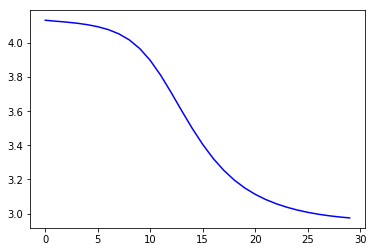

Epoch:  1  Train cost:  5.170347629145219
Epoch:  2  Train cost:  5.1644119427768835
Epoch:  3  Train cost:  5.158536991141474
Epoch:  4  Train cost:  5.151048302334185
Epoch:  5  Train cost:  5.141077228109707
Epoch:  6  Train cost:  5.127264644547842
Epoch:  7  Train cost:  5.107578319879328
Epoch:  8  Train cost:  5.0790720071191044
Epoch:  9  Train cost:  5.037763268157149
Epoch:  10  Train cost:  4.979053829843444
Epoch:  11  Train cost:  4.899833592203714
Epoch:  12  Train cost:  4.802031412945695
Epoch:  13  Train cost:  4.694099641176244
Epoch:  14  Train cost:  4.586495469449355
Epoch:  15  Train cost:  4.486912110003767
Epoch:  16  Train cost:  4.399208777618507
Epoch:  17  Train cost:  4.324581129176194
Epoch:  18  Train cost:  4.26262346111794
Epoch:  19  Train cost:  4.212151632394895
Epoch:  20  Train cost:  4.171565295076249
Epoch:  21  Train cost:  4.139171417979279
Epoch:  22  Train cost:  4.113474789218169
Epoch:  23  Train cost:  4.093203422104808
Epoch:  24  Train c

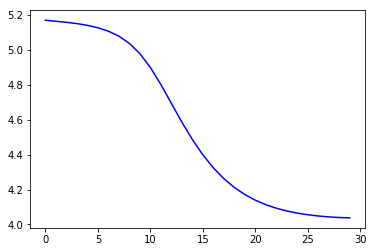

Epoch:  1  Train cost:  2.7503966859642968
Epoch:  2  Train cost:  2.743996906382915
Epoch:  3  Train cost:  2.740223532537209
Epoch:  4  Train cost:  2.7353982009510354
Epoch:  5  Train cost:  2.72900193845727
Epoch:  6  Train cost:  2.720361202713845
Epoch:  7  Train cost:  2.708424955982215
Epoch:  8  Train cost:  2.691592808746662
Epoch:  9  Train cost:  2.6676003227350744
Epoch:  10  Train cost:  2.6345034204965505
Epoch:  11  Train cost:  2.591169581970312
Epoch:  12  Train cost:  2.5363716878144698
Epoch:  13  Train cost:  2.4695142887468045
Epoch:  14  Train cost:  2.3917644067432966
Epoch:  15  Train cost:  2.3047180597373806
Epoch:  16  Train cost:  2.211139022780016
Epoch:  17  Train cost:  2.1153440527474108
Epoch:  18  Train cost:  2.02223567447721
Epoch:  19  Train cost:  1.9359590314930564
Epoch:  20  Train cost:  1.858969631613787
Epoch:  21  Train cost:  1.7919118333059654
Epoch:  22  Train cost:  1.7341330523374692
Epoch:  23  Train cost:  1.6843609299207871
Epoch:  2

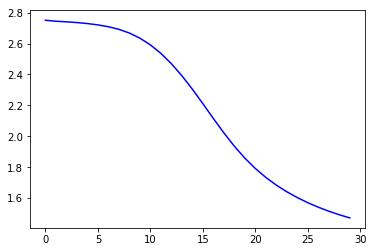

Optimal hidden layer size: 250
Epoch:  1  Train cost:  4.698906263100784
Epoch:  2  Train cost:  4.692815756504688
Epoch:  3  Train cost:  4.686933793624699
Epoch:  4  Train cost:  4.679326696545371
Epoch:  5  Train cost:  4.669062801245642
Epoch:  6  Train cost:  4.654674069410851
Epoch:  7  Train cost:  4.6339582030275075
Epoch:  8  Train cost:  4.603722786395487
Epoch:  9  Train cost:  4.5596985120697715
Epoch:  10  Train cost:  4.497245343502297
Epoch:  11  Train cost:  4.413955601298989
Epoch:  12  Train cost:  4.312191179144515
Epoch:  13  Train cost:  4.198603894826825
Epoch:  14  Train cost:  4.082903491637303
Epoch:  15  Train cost:  3.974796133714488
Epoch:  16  Train cost:  3.8805209419295936
Epoch:  17  Train cost:  3.8020981859828185
Epoch:  18  Train cost:  3.738670879349788
Epoch:  19  Train cost:  3.688121646780131
Epoch:  20  Train cost:  3.647999844026766
Epoch:  21  Train cost:  3.616091645438723
Epoch:  22  Train cost:  3.590570562335416
Epoch:  23  Train cost:  3.5

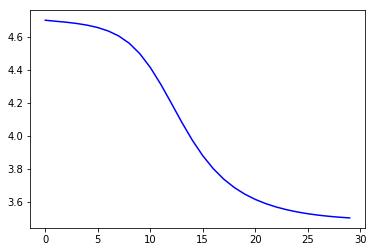

Test accuracy:  82.70827082708271


In [18]:
for layer_size in hidden_layer_sizes:
    loss, train_loss, parameters = run(X_train_without_validation, y_train_without_validation, X_train_validation, y_train_validation, layer_size)
    if loss < minimum_loss:
        minimum_loss = loss
        hidden_layer_size = layer_size

    plt.plot(range(len(train_loss)), train_loss, color='blue')
    plt.show()

print('Optimal hidden layer size:', hidden_layer_size)

loss, train_loss, parameters = run(X_train, y_train, X_test, y_test, hidden_layer_size)

plt.plot(range(len(train_loss)), train_loss, color='blue')
plt.show()

prediction = forwardPropagation(X_test, parameters[0], parameters[1], parameters[2], parameters[3], rectifiedLinearUnit, softmax)
test_accuracy = accuracy(prediction[1], y_test)
print('Test accuracy: ', test_accuracy)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])